# Segmenting images from a dataset

This notebook demonstrates how pretrained models can be used to perform semantic segmentation on a set of images and compute some statistics on the identified objects.

In the future, Streetscapes may include bespoke models trained on specific tasks, such as detecting materials in images and video.

## Setup

Import all the packages that we will need below and set up some convenience variables.

In [1]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
from PIL import Image

# --------------------------------------
import numpy as np

# --------------------------------------
import matplotlib.pyplot as plt

# --------------------------------------
import streetscapes as scs
from streetscapes.enums import Stat
from streetscapes.enums import Attr

Load or generate a subset of the streetscapes dataset.

In [2]:
# Define the criteria for creating the subset
criteria = {
    "city": "Amsterdam",  # Equivalent to "city": (operator.eq, "Amsterdam")
    "view_direction": "side",
    "lighting_condition": "day",
}

# Define the columns to keep in the subset
columns = ["uuid", "source", "orig_id", "lat", "lon"]

# Create or load the subset
amsterdam_side = scs.load_subset(
    "amsterdam_side",
    criteria=criteria,
    columns=columns,
    recreate=True,
    save=False,
)

Streetscapes | 2025-03-20@16:10:30 | Creating subset 'amsterdam_side'...
Streetscapes | 2025-03-20@16:10:31 | Done


We will first process one image (chosen at random from the dataset we loaded above) in order to understand how the pipeline works.

<span style="color:red;">Note</span>: please make sure that you download some images first (cf. `download_city_images.ipynb`).

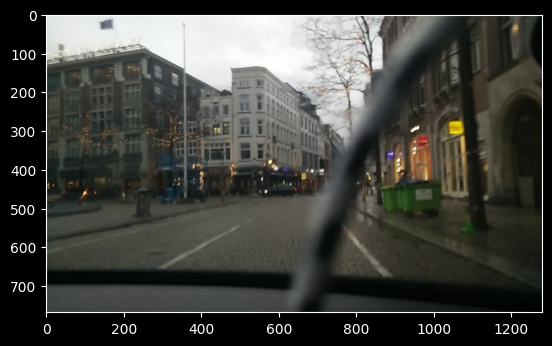

In [3]:
sample_id = amsterdam_side.to_pandas().sample(1)["orig_id"].values[0]
sample_image = scs.conf.IMAGE_DIR / f"{sample_id}.jpeg"
img_data = np.array(Image.open(sample_image))
plt.imshow(img_data)

We define some categories of objects that we would like to extract. The categories can be defined hierarchically so that categories deeper in the hierarchy would be 'subtracted' from their parents ones. For instance, this can be used to instruct the model to extract 'building' objects _without_ 'window' or 'door' objects. This example is used below.

In [4]:
labels = {
    "sky": None,
    "building": {
        "window": None,
        "door": None,
    },
    "tree": None,
    "car": None,
    "truck": None,
    "road": None,
}

Furthermore, we define the attributes and the types of statistics for those attributes that we would like to extract from the segmented images.

In [5]:
attrs = {Attr.H, Attr.Area}
stats = {Stat.Mean}

## MaskFormer

First, we will use the MaskFormer model for segmentation. This model is built on the pretrained [`Mask2FormerForUniversalSegmentation`](https://huggingface.co/docs/transformers/en/model_doc/mask2former) model, which is an implementation of the [`Mask2Former`](https://arxiv.org/abs/2112.01527) model from FAIR.

In [6]:
mf_model = scs.models.MaskFormer()

First, segment the image and extract some metadata (object instances, colour statistics, latitude and longitude...).

In [7]:
mf_images, mf_masks, mf_instances = mf_model.segment(sample_image, labels)

Streetscapes | 2025-03-20@16:10:33 | Segmenting images...
Streetscapes | 2025-03-20@16:10:33 | Detecting objects...
Streetscapes | 2025-03-20@16:10:35 | [ 155376843208938.jpeg ] Extracted 1 instances for 14 labels.


Extract the statistics for the segmented image.

In [8]:
mf_stats = mf_model.extract_stats(
    mf_images,
    mf_masks,
    mf_instances,
    attrs=attrs,
    stats=stats,
)

Streetscapes | 2025-03-20@16:10:35 | Extracting metadata...


100%|██████████| 19/19 [00:00<00:00, 348.93it/s]


Show the extracted instance IDs with their labels.

In [9]:
mf_instances

{155376843208938: {1: 'pole',
  2: 'building',
  3: 'car',
  4: 'curb',
  5: 'sky',
  6: 'car-mount',
  7: 'pole',
  8: 'person',
  9: 'lane-marking-general',
  10: 'billboard',
  11: 'trash-can',
  12: 'sidewalk',
  13: 'trash-can',
  14: 'pole',
  15: 'ego-vehicle',
  16: 'vegetation',
  17: 'road',
  18: 'trash-can',
  19: 'pole'}}

## Visualisation

Select a few labels of interest. Only these labels will be highlighted in the visualisation.

In [10]:
highlight = {"building", "sky", "road", "window"}

Select one of the segmented images.

In [11]:
mf_orig_id, mf_image = next(iter(mf_images.items()))

Visualise the image and the highlighted instances.

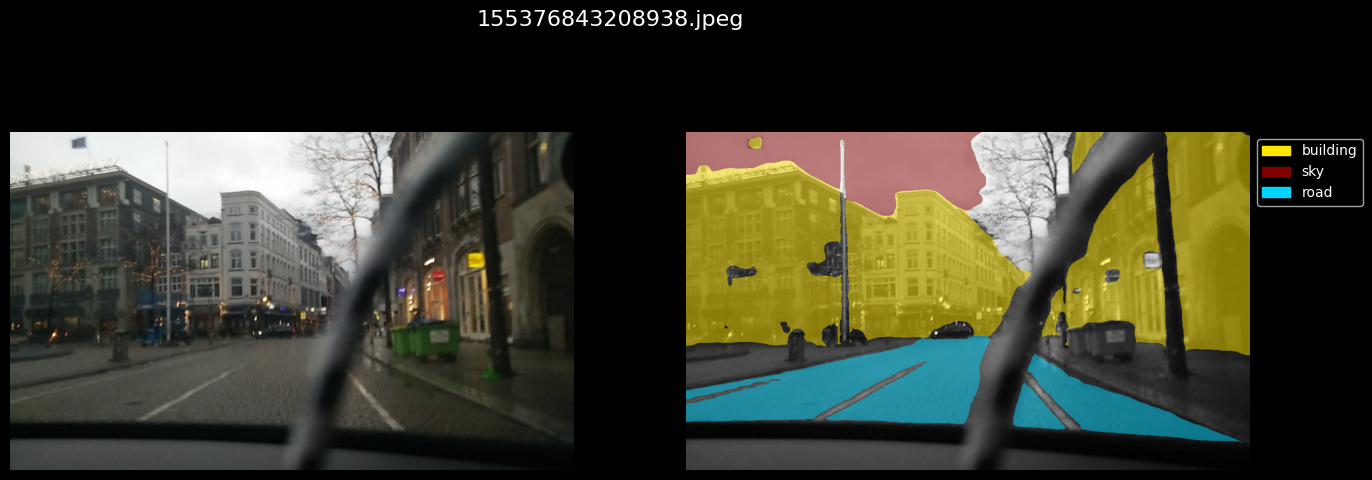

In [12]:
(fig, ax) = mf_model.visualise_segmentation(
    mf_image,
    mf_masks[mf_orig_id],
    mf_instances[mf_orig_id],
    highlight,
    title=sample_image.name,
)

## Process multiple entries from the dataset at once

The segmentation model also provides a convenience method to process multiple images in a subset of the `streetscapes` dataset at once. We will use the `sample` method to extract a small subset of a few images of the dataset at random. Those images will be segmented, and the corresponding metadata (statistics about the colour of the detected instances, instance masks, latitude and longitude of the place where the image was taken, and so forth) will be stored in a separate Parquet file for each image, with the same name as the image itself (and the extension `.parquet`) in the default directory for `parquet` files. This would allow us to segment a large dataset once and load the results later.

In [13]:
mf_image_paths, mf_mask_paths, mf_stat_paths = mf_model.segment_from_dataset(
    amsterdam_side,
    labels,
    sample=3,
    attrs=attrs,
    stats=stats,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Streetscapes | 2025-03-20@16:10:36 | Segmenting images...
Streetscapes | 2025-03-20@16:10:36 | Detecting objects...
Streetscapes | 2025-03-20@16:10:45 | [ 133460415937530.jpeg ] Extracted 1 instances for 15 labels.
Streetscapes | 2025-03-20@16:10:45 | [ 794057258189881.jpeg ] Extracted 2 instances for 7 labels.
Streetscapes | 2025-03-20@16:10:45 | [ 726127431858469.jpeg ] Extracted 3 instances for 15 labels.
Streetscapes | 2025-03-20@16:10:45 | Extracting metadata...


100%|██████████| 1/1 [00:11<00:00, 11.16s/it]


Load the segmentation masks and the statistics from the respective files on disk.

In [14]:
mf_masks = mf_model.load_masks(mf_mask_paths)
mf_masks

{133460415937530: array([[24, 24, 24, ...,  8,  8,  8],
        [24, 24, 24, ...,  8,  8,  8],
        [24, 24, 24, ...,  8,  8,  8],
        ...,
        [25, 25, 25, ..., 22, 22, 22],
        [25, 25, 25, ..., 22, 22, 22],
        [25, 25, 25, ..., 22, 22, 22]], shape=(1536, 2048), dtype=int32),
 794057258189881: array([[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]], shape=(1200, 800), dtype=int32),
 726127431858469: array([[ 1,  1,  1, ...,  6,  6,  6],
        [ 1,  1,  1, ...,  6,  6,  6],
        [ 1,  1,  1, ...,  6,  6,  6],
        ...,
        [18, 18, 18, ..., 18, 18, 18],
        [18, 18, 18, ..., 18, 18, 18],
        [18, 18, 18, ..., 18, 18, 18]], shape=(1536, 2048), dtype=int32)}

In [15]:
mf_stats = mf_model.load_stats(mf_stat_paths)
mf_stats

{133460415937530: {'instance': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29],
  'label': ['bicycle',
   'billboard',
   'bicycle',
   'building',
   'person',
   'pole',
   'bicyclist',
   'sky',
   'bicycle',
   'bicycle',
   'bicycle',
   'pole',
   'bicycle',
   'lane-marking-general',
   'wall',
   'person',
   'pole',
   'sidewalk',
   'pole',
   'billboard',
   'curb-cut',
   'bicycle',
   'street-light',
   'vegetation',
   'road',
   'traffic-sign-front',
   'traffic-sign-front',
   'bicycle',
   'traffic-sign-front'],
  <Attr.H: 'h'>: {<Stat.Mean: 'mean'>: [0.40513038458823947,
    0.5829300823467717,
    0.4464200016451542,
    0.3718824893541839,
    0.6237246135595812,
    0.5418684157508846,
    0.7001184109890216,
    0.011713433203138892,
    0.5942400215105157,
    0.5147073494233674,
    0.19066687063056068,
    0.51075975798

Pick an image from the sample list. We are going to visualise its segmentation.

In [16]:
mf_orig_id, mf_image = mf_model.load_image(mf_image_paths[0])
list(zip(mf_stats[mf_orig_id]["label"], mf_stats[mf_orig_id][Attr.H][Stat.Mean]))

[('bicycle', 0.40513038458823947),
 ('billboard', 0.5829300823467717),
 ('bicycle', 0.4464200016451542),
 ('building', 0.3718824893541839),
 ('person', 0.6237246135595812),
 ('pole', 0.5418684157508846),
 ('bicyclist', 0.7001184109890216),
 ('sky', 0.011713433203138892),
 ('bicycle', 0.5942400215105157),
 ('bicycle', 0.5147073494233674),
 ('bicycle', 0.19066687063056068),
 ('pole', 0.5107597579815415),
 ('bicycle', 0.639067147630634),
 ('lane-marking-general', 0.22015095176451127),
 ('wall', 0.35726010093124017),
 ('person', 0.5468321431106926),
 ('pole', 0.425027418735511),
 ('sidewalk', 0.30766494452663257),
 ('pole', 0.5878156216808151),
 ('billboard', 0.5988201514041944),
 ('curb-cut', 0.36685686990692434),
 ('bicycle', 0.4779179088388083),
 ('street-light', 0.5617607681727299),
 ('vegetation', 0.2333999138751964),
 ('road', 0.139559291616786),
 ('traffic-sign-front', 0.8414685211351725),
 ('traffic-sign-front', 0.6303615457056518),
 ('bicycle', 0.4082285842535971),
 ('traffic-sign

The statistics are stored in `parquet` files with the same name and path as the image, with the extension `.stat.parquet`. They can be loaded back into a dictionary by using the `model.load_stats()` method. Keep in mind that although we use `Attr` and `Stat` elements (cf. `streetscapes.enums`) as dictionary keys, those can be indexed as strings (e.g., `Attr['Area']` is equivalent to `Attr.Area`). 

We will visualise the segmentation with the loaded metadata to ensure that it works.

In [17]:
mf_instances = {
    inst_id: label
    for inst_id, label in zip(
        mf_stats[mf_orig_id]["instance"], mf_stats[mf_orig_id]["label"]
    )
}

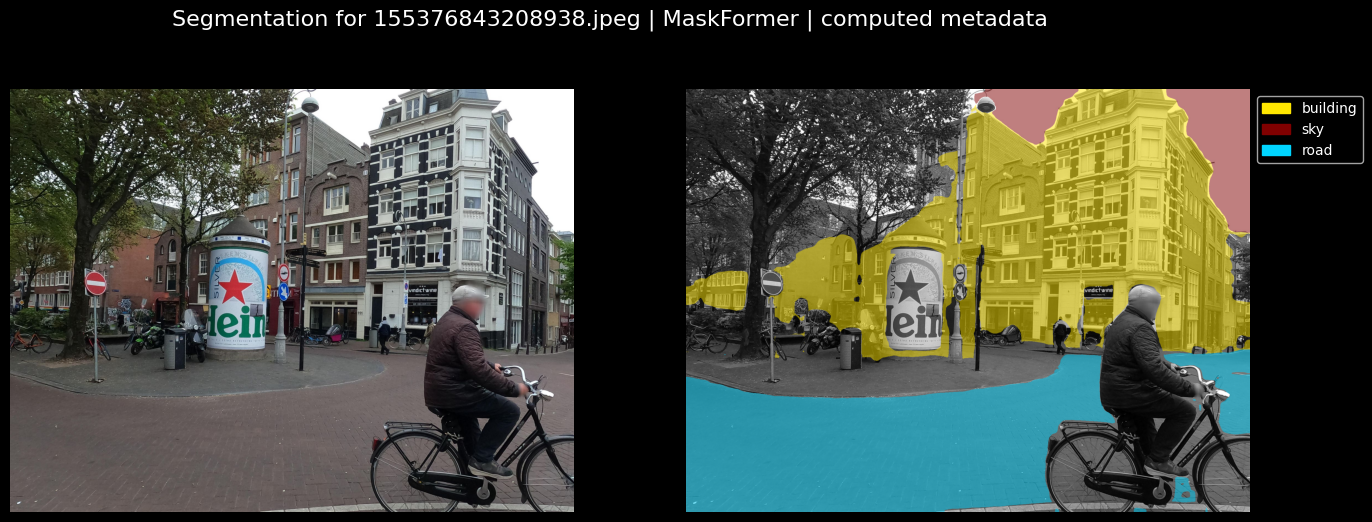

In [18]:
(fig, ax) = mf_model.visualise_segmentation(
    mf_image,
    mf_masks[mf_orig_id],
    mf_instances,
    highlight,
    title=f"Segmentation for {sample_image.name} | MaskFormer | computed metadata",
)

## DinoSAM

Next, we will apply the same pipeline to another model: `DinoSAM`. The implementation of DinoSAM was insipred heavily by two existing projects: [Language Segment-Anything (LangSAM)](https://github.com/luca-medeiros/lang-segment-anything?tab=readme-ov-file) and [SamGeo](https://samgeo.gishub.org/).

In a nutshell, DinoSAM uses the [`GroundingDINO`](https://huggingface.co/IDEA-Research/grounding-dino-base) for object detection and labelling and [`SAM2`](https://github.com/facebookresearch/sam2) models for semantic segmentation. The result is a model tha can segment images into instances of objects requested via a **textual prompt**.

We will use the same dataset as the MaskFormer model.

In [19]:
ds_model = scs.models.DinoSAM()

In [20]:
ds_images, ds_masks, ds_instances = ds_model.segment(sample_image, labels)

Streetscapes | 2025-03-20@16:10:53 | [ 155376843208938 ] Detecting objects...
Streetscapes | 2025-03-20@16:11:05 | [ 155376843208938 ] Performing segmentation...
Streetscapes | 2025-03-20@16:11:19 | [ 155376843208938 ] Removing overlaps...
Streetscapes | 2025-03-20@16:11:19 | [ 155376843208938 ] Extracted 54 instances for 8 labels.


Extract the statistics for the sample image, as in the case of the MaskFormer model.

In [21]:
ds_image_stats = ds_model.extract_stats(
    ds_images, ds_masks, ds_instances, attrs=attrs, stats=stats
)

Streetscapes | 2025-03-20@16:11:19 | Extracting metadata...


100%|██████████| 54/54 [00:00<00:00, 383.98it/s]


Show the instances and statistics

In [22]:
ds_instances

{155376843208938: {1: 'tree',
  2: 'tree',
  3: 'window',
  4: 'window',
  5: 'window',
  6: 'window',
  7: 'window',
  8: 'window',
  9: 'window',
  10: 'window',
  11: 'window',
  12: 'window',
  13: 'window',
  14: 'window',
  15: 'window',
  16: 'window',
  17: 'window',
  18: 'road',
  19: 'window',
  20: 'window',
  21: 'window',
  22: 'window',
  23: 'building',
  24: 'window',
  25: 'window',
  26: 'window',
  27: 'window',
  28: 'window',
  29: 'window',
  30: 'window',
  31: 'door',
  32: 'window',
  33: 'car',
  34: 'window',
  35: 'door',
  36: 'window',
  37: 'building',
  38: 'building',
  39: 'door',
  40: 'window',
  41: 'window',
  42: 'window',
  43: 'window',
  44: 'window',
  45: 'window',
  46: 'tree',
  47: 'window',
  48: 'window',
  49: 'window',
  50: 'window',
  51: 'building',
  52: 'sky',
  53: 'building',
  54: 'truck'}}

In [23]:
ds_image_stats

{155376843208938: {'instance': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54],
  'label': ['tree',
   'tree',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'road',
   'window',
   'window',
   'window',
   'window',
   'building',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'door',
   'window',
   'car',
   'window',
   'door',
   'window',
   'building',
   'building',
   'door',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'tree',
   'w

Visualise the segmentation. DinoSAM is more detailed, and it can identify objects such as windows as separate instances.

In [24]:
ds_orig_id, ds_image = next(iter(ds_images.items()))

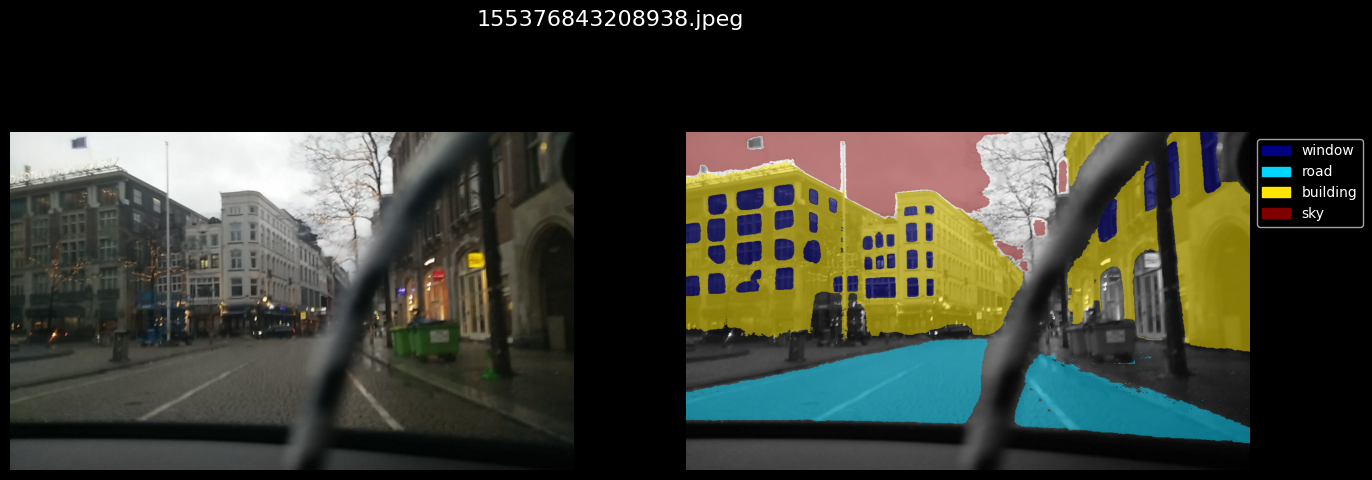

In [25]:
(fig, ax) = mf_model.visualise_segmentation(
    ds_image,
    ds_masks[ds_orig_id],
    ds_instances[ds_orig_id],
    highlight,
    title=sample_image.name,
)

We can also segment a subset of our dataset with DinoSAM, with the same API as the MaskFormer model.

In [26]:
ds_image_paths, ds_mask_paths, ds_stat_paths = ds_model.segment_from_dataset(
    amsterdam_side, labels, sample=3, attrs=attrs, stats=stats
)

  0%|          | 0/1 [00:00<?, ?it/s]

Streetscapes | 2025-03-20@16:11:20 | [ 580633342 ] Detecting objects...
Streetscapes | 2025-03-20@16:11:32 | [ 580633342 ] Performing segmentation...
Streetscapes | 2025-03-20@16:11:42 | [ 580633342 ] Removing overlaps...
Streetscapes | 2025-03-20@16:11:42 | [ 580633342 ] Extracted 14 instances for 4 labels.
Streetscapes | 2025-03-20@16:11:42 | [ 521068232387876 ] Detecting objects...
Streetscapes | 2025-03-20@16:11:51 | [ 521068232387876 ] Performing segmentation...
Streetscapes | 2025-03-20@16:12:03 | [ 521068232387876 ] Removing overlaps...
Streetscapes | 2025-03-20@16:12:03 | [ 521068232387876 ] Extracted 59 instances for 5 labels.
Streetscapes | 2025-03-20@16:12:03 | [ 1209324 ] Detecting objects...
Streetscapes | 2025-03-20@16:12:14 | [ 1209324 ] Performing segmentation...
Streetscapes | 2025-03-20@16:12:28 | [ 1209324 ] Removing overlaps...
Streetscapes | 2025-03-20@16:12:28 | [ 1209324 ] Extracted 44 instances for 8 labels.
Streetscapes | 2025-03-20@16:12:28 | Extracting metada

100%|██████████| 1/1 [01:13<00:00, 73.72s/it]


Load the statistics and the masks.

In [27]:
ds_stats = ds_model.load_stats(ds_stat_paths)
ds_stats

{580633342: {'instance': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  'label': ['car',
   'car',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'window',
   'road',
   'building',
   'window',
   'window',
   'road'],
  <Attr.H: 'h'>: {<Stat.Mean: 'mean'>: [0.3873842909628962,
    0.49229472962834,
    0.4444310880598772,
    0.20465936766944617,
    0.2601609333707602,
    0.49783430537898926,
    0.5246070681415923,
    0.49485263765017856,
    0.12625528698088884,
    0.2990633580606231,
    0.2097925050000779,
    0.14099966598987443,
    0.5022337696551049,
    0.2024171467146999]},
  <Attr.Area: 'area'>: [0.2550326554232804,
   0.03852677259175275,
   0.012166474421558746,
   0.028763033955866296,
   0.02457948843117494,
   0.016476652389350803,
   0.01751415265180146,
   0.014900390132905016,
   0.033690052988788105,
   7.520851704879483e-05,
   0.39334464495674815,
   0.021454603253338377,
   0.0017425903617619889,
   0.10129086356764928]

In [30]:
ds_masks = ds_model.load_masks(ds_mask_paths)
ds_masks

{580633342: array([[11, 11, 11, ..., 11, 11, 11],
        [11, 11, 11, ..., 11, 11, 11],
        [11, 11, 11, ..., 11, 11, 11],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], shape=(3024, 4032), dtype=uint32),
 521068232387876: array([[56, 56, 56, ...,  0,  0,  0],
        [56, 56, 56, ...,  0,  0,  0],
        [56, 56, 56, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], shape=(1536, 2048), dtype=uint32),
 1209324: array([[ 0,  0,  0, ..., 41, 41, 41],
        [ 0,  0,  0, ..., 41, 41, 41],
        [ 0,  0,  0, ..., 41, 41, 41],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], shape=(1936, 2592), dtype=uint32)}

Pick an image from the sampled pool.

In [28]:
ds_orig_id, ds_image = ds_model.load_image(ds_image_paths[0])
list(zip(ds_stats[ds_orig_id]["label"], ds_stats[ds_orig_id][Attr.H][Stat.Mean]))

[('car', 0.3873842909628962),
 ('car', 0.49229472962834),
 ('window', 0.4444310880598772),
 ('window', 0.20465936766944617),
 ('window', 0.2601609333707602),
 ('window', 0.49783430537898926),
 ('window', 0.5246070681415923),
 ('window', 0.49485263765017856),
 ('window', 0.12625528698088884),
 ('road', 0.2990633580606231),
 ('building', 0.2097925050000779),
 ('window', 0.14099966598987443),
 ('window', 0.5022337696551049),
 ('road', 0.2024171467146999)]

Create a dictionary of instances and labels for the selected image. We can use that to visualise the segmentation.

In [29]:
ds_instances = {
    inst_id: label
    for inst_id, label in zip(
        ds_stats[ds_orig_id]["instance"], ds_stats[ds_orig_id]["label"]
    )
}

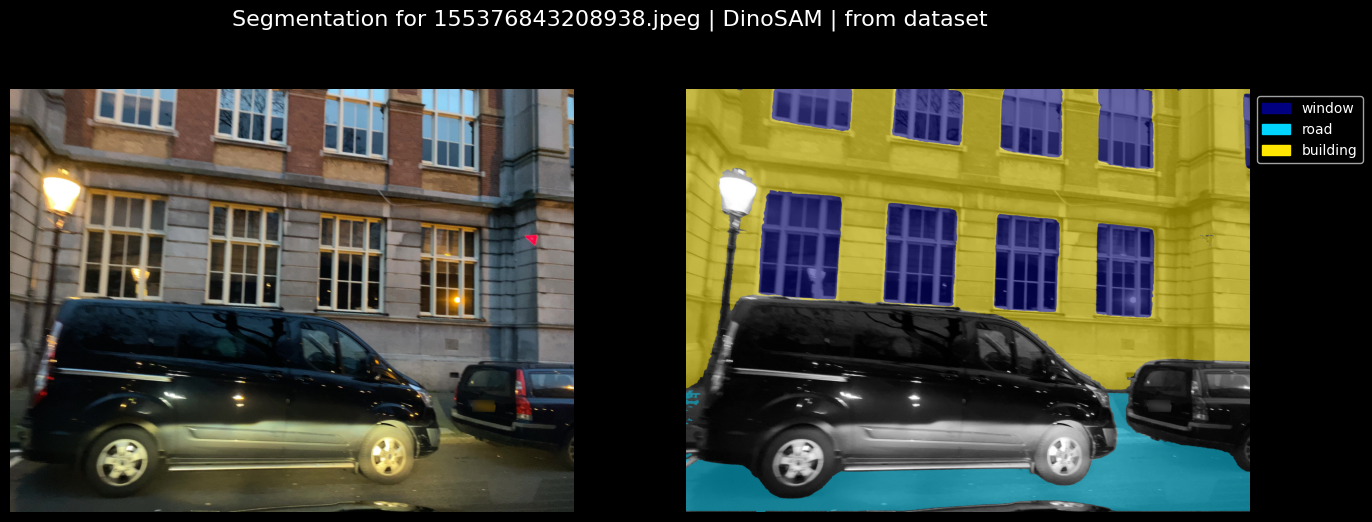

In [32]:
(fig, ax) = ds_model.visualise_segmentation(
    ds_image,
    ds_masks[ds_orig_id],
    ds_instances,
    highlight,
    title=f"Segmentation for {sample_image.name} | DinoSAM | from dataset",
)